## Split Webpage Content in Chunks

In [1]:
import os
import sys

# Needed to import modules from parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features
from transformers import AutoTokenizer
import pandas as pd 
import numpy as np
import torch
from collections import Counter
import random

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging
from transformers import logging as transformers_logging

# Set the logging level to error for transformers, which will suppress warnings
transformers_logging.set_verbosity_error()


**Load Examples:**

In [4]:
topic = "cannabis" #"energie" ✅ "kinder" ✅  "cannabis" ✅
sampling = "shared_domain" # "random" ✅✅✅, "stratified" ✅✅✅, "clustered" ✅✅✅, "shared_domain" ✅✅✅
suffix = "_extended" #""✅, "_holdout", "_extended" ✅

MODEL_NAME = "FacebookAI/xlm-roberta-base"
MAX_CONTENT_LENGTH = 384 # 496, 192
OVERLAP = 64

NUM_THREADS = 26

In [5]:
#dataset = load_from_disk(f"../../data//tmp/processed_dataset_{topic}_buffed_random")
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_{sampling}{suffix}")
print(dataset)
print(dataset["test"][1])

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
        num_rows: 410
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
        num_rows: 46
    })
    holdout: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
        num_rows: 3448
    })
    extended: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', '

**Chunkify Exmaples:**

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

In [7]:
# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [8]:
def get_input_length(text):
    """ Tokenize the input text and return the number of tokens """
    return len(tokenizer.encode(text, add_special_tokens=True, truncation=False, padding=False))

print(get_input_length("Hello, my name is John Doe"))

10


In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=MAX_CONTENT_LENGTH,
    chunk_overlap=OVERLAP,
    length_function=get_input_length,
    separators = ["\n\n", "\n", ".", "?", "!", " ", ""]
)

# text_splitter = CharacterTextSplitter(
#     separator = ".", # Split text by sentences
#     chunk_size=MAX_CONTENT_LENGTH,
#     chunk_overlap=OVERLAP,
#     length_function=get_input_length,
#     is_separator_regex=False,
# )

In [10]:
test_text = dataset['train'][0]['text']
#print(test_text)

texts = text_splitter.split_text(test_text)
print(len(texts)) 

print(texts[0])
print("Length of text:", get_input_length(texts[0]))

8
News Ratgeber Finanzen & Verbraucher Verbraucher "Shoppe wie Milliardäre": Wie seriös ist die Temu-App? Aktualisiert am 04.07.2023, 11:17 Uhr Wie seriös ist Temu wirklich? © IMAGO/NurPhoto/Jakub Porzycki Lesedauer: 5 Min. Teilen Artikel teilen Von Lisa-Marie Yilmaz Sie ist die aktuelle Nummer 1 der Shopping-Apps: Temu. Aber was genau hat es mit der App aus China auf sich? Wir haben uns die Plattform einmal genauer angeschaut. Mehr zum Thema Verbraucher Vorbei sind die Zeiten, in denen WhatsApp , TikTok oder ChatGPT die Charts der Top-Gratis Apps in den App- und Play-Stores von iOS und Android anführten. Denn Deutschlands neue Nummer 1 heißt aktuell Temu – mehr als 50 Millionen Mal wurde das digitale Shopping-Portal bereits heruntergeladen. Was hat es mit der Shopping-App aus China auf sich, woher kommt der Hype und ist der Online-Marktplatz eigentlich seriös? Ein Überblick. "Shoppe wie die Milliardäre" – getreu diesem Motto wirbt Temu, die Shopping-App aus China und lockt nicht nur m

In [11]:
def expandRow(row, col_name):
    """
    Generate prompts based on text chunks from the input row.
    """
    rows = []

    # Split the text into chunks
    text_chunks = text_splitter.split_text(row.get(col_name, ""))

    # Generate prompts for each text chunk
    for chunk_id, text_chunk in enumerate(text_chunks):
        new_row = {
            **row, 'chunk_id': chunk_id, 'text': text_chunk
        }
        rows.append(new_row)

    return rows

In [12]:
from multiprocessing import Pool


def processDataset(dataset, num_processes, func, params=()):
    """Process a list of articles in parallel using a multiprocessing Pool."""

    # Creates a list of arguments for each call to func
    # Uses starmap to pass multiple arguments to func
    with Pool(processes=num_processes) as pool:
        args = [(row,) + params for row in dataset]
        dataset = list(pool.starmap(func, args))

    # Flatten the resulting list of lists
    # and convert it into a Dataset
    dataset = [item for sublist in dataset for item in sublist]
    dataset = Dataset.from_dict(
        {key: [dic[key] for dic in dataset] for key in dataset[0]})

    return dataset

In [13]:
params = ("text",)

for split in dataset:
    dataset[split] = processDataset(dataset[split], NUM_THREADS, expandRow, params)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [14]:
label_counts = Counter(dataset["train"]['label'])
print("Class frequencies:", label_counts)

Class frequencies: Counter({0: 2056, 1: 1997})


In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id'],
        num_rows: 4053
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id'],
        num_rows: 507
    })
    holdout: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id'],
        num_rows: 33464
    })
    extended: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length

In [16]:
def update_metrics(example):
    example['text_length'] = len(example['text'])
    example['word_count'] = len(example['text'].split())
    example['token_count'] = get_input_length(example['text'])
    return example

dataset = dataset.map(update_metrics, num_proc=NUM_THREADS)

Map (num_proc=26): 100%|██████████| 224737/224737 [00:39<00:00, 5732.18 examples/s] 


In [17]:
dataset["train"][0]

{'_id': '64b2b8a46b2e16875552e442',
 'batch_id': 17,
 'domain': 'gmx.net',
 'view_url': 'www.gmx.net/magazine/ratgeber/finanzen-verbraucher/schnaeppchen-app-temu-guenstig-serioes-38371568#.homepage.hero.Schon%20von%20Temu%20geh%C3%B6rt?%20Das%20steckt%20hinter%20der%20neuen%20Schn%C3%A4ppchen-App.3',
 'lang': 'de',
 'text': 'News Ratgeber Finanzen & Verbraucher Verbraucher "Shoppe wie Milliardäre": Wie seriös ist die Temu-App? Aktualisiert am 04.07.2023, 11:17 Uhr Wie seriös ist Temu wirklich? ©\xa0IMAGO/NurPhoto/Jakub Porzycki Lesedauer: 5 Min. Teilen Artikel teilen Von Lisa-Marie Yilmaz Sie ist die aktuelle Nummer 1 der Shopping-Apps: Temu. Aber was genau hat es mit der App aus China auf sich? Wir haben uns die Plattform einmal genauer angeschaut. Mehr zum Thema Verbraucher Vorbei sind die Zeiten, in denen WhatsApp , TikTok oder ChatGPT die Charts der Top-Gratis Apps in den App- und Play-Stores von iOS und Android anführten. Denn Deutschlands neue Nummer 1 heißt aktuell Temu – mehr a

In [18]:
# dataset.save_to_disk(f"../../data//tmp/processed_dataset_{topic}_buffed_chunkified_random_{MAX_CONTENT_LENGTH}") # TODO

dataset.save_to_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_{sampling}{suffix}_{MAX_CONTENT_LENGTH}")

Saving the dataset (1/1 shards): 100%|██████████| 224737/224737 [00:00<00:00, 414720.49 examples/s]


## Statistics

In [19]:
token_counts = dataset["train"]["token_count"]

In [20]:
max_token_count = max(token_counts)
min_token_count = min(token_counts)
avg_token_count = sum(token_counts) / len(token_counts)
std_token_count = np.std(token_counts)  # Using numpy for standard deviation

print(f"Maximum token count: {max_token_count}")
print(f"Minimum token count: {min_token_count}")
print(f"Average token count: {avg_token_count}")
print(f"Standard deviation of token count: {std_token_count}")

Maximum token count: 382
Minimum token count: 3
Average token count: 250.68936590180112
Standard deviation of token count: 91.55785782930504


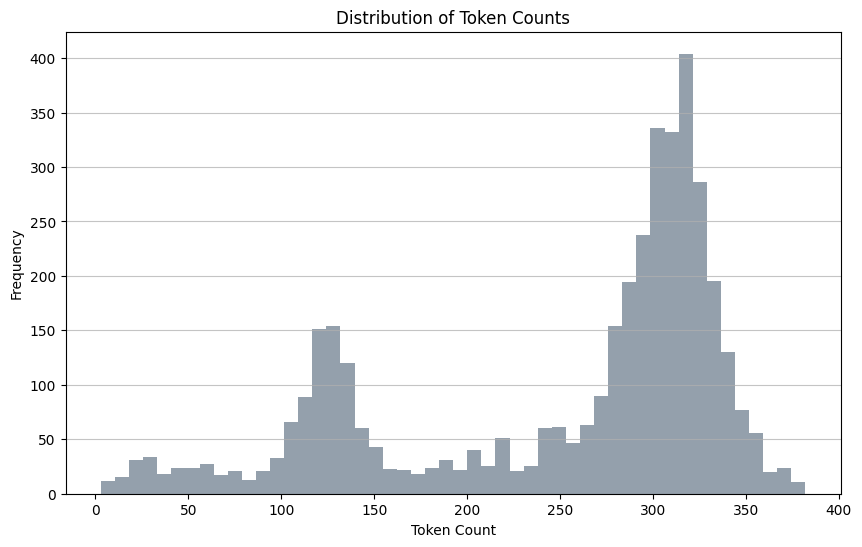

In [21]:
import matplotlib.pyplot as plt

# Plotting the distribution of token counts with a more muted color
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, alpha=0.75, color='slategray')
plt.title('Distribution of Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [22]:
# Initialize a dictionary to keep track of the first example encountered in each interval
selected_examples = {}

# Example iteration over the dataset
for example in dataset["train"]:
    interval = (example['token_count'] // 50) * 50
    if interval not in selected_examples:
        selected_examples[interval] = example

# Sort the selected examples by their interval (token count range) before printing
sorted_intervals = sorted(selected_examples.keys())

# Now, print one example for each interval, in order
for interval in sorted_intervals:
    example = selected_examples[interval]
    print(f"Interval: {interval} tokens to {interval + 49} tokens")
    print(f"Example Text: {example['text']}")
    print(f"Token Count: {example['token_count']}")
    print("-" * 80)


Interval: 0 tokens to 49 tokens
Example Text: Währungsrechner Versicherungen Nachrichtenarchiv Facebook Twitter Wo Sie uns noch folgen können Tarifkonflikt Bahngewerkschaft EVG sagt Streik ab Bahnreisende bleiben vorerst von weiteren Ausständen verschont
Token Count: 48
--------------------------------------------------------------------------------
Interval: 50 tokens to 99 tokens
Example Text: . Dies sei nicht ausreichend. Der bei der Deutschen Bahn für den Personenfernverkehr zuständige Vorstand Michael Peterson hatte die EVG zu einer raschen Annahme der Schlichtungsgespräche aufgefordert. »Die Sommerferien stehen vor der Tür«, sagte er. »Die neuerlichen Streikdrohungen verunsichern alle Menschen, die bei ihren Reiseplanungen auf die Bahn gesetzt haben
Token Count: 85
--------------------------------------------------------------------------------
Interval: 100 tokens to 149 tokens
Example Text: Zum Inhalt springen DER SPIEGEL Wirtschaft Abonnement Abo Anmelden Menü öffnen News Tick